## Реализация случайного леса

Для лучшего понимания алгоритма построения случайного леса реализуем его на Python.

In [83]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [84]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

In [85]:
classification_labels

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1])

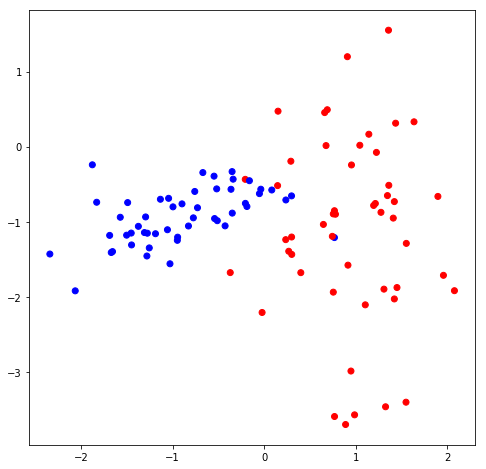

In [86]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [87]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [88]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

Далее повторим реализацию построения дерева решений из предыдущего урока с некоторыми изменениями

In [89]:
# Реализуем класс узла

class Node:    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        quality, t, index = find_best_split(data, labels)
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.q = quality
        print('q=',quality)
        self.true_branch = None  # поддерево, удовлетворяющее условию в узле
        self.false_branch = None  # поддерево, не удовлетворяющее условию в узле

    def Add(self):
        true_data, false_data, true_labels, false_labels = split(self.data, self.labels, self.index, self.t)
        node1 = Node(true_data, true_labels)  
        if (node1.q == 0):
            self.true_branch = Leaf(true_data, true_labels)
        else:
            self.true_branch = node1
        node2 = Node(false_data, false_labels)  
        if (node2.q == 0):        
            self.false_branch = Leaf(false_data, false_labels)
        else:
            self.false_branch = node2
       
        return self.true_branch, self.false_branch


In [90]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [91]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [92]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [93]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [94]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

Теперь добавим функцию формирования случайного леса.

1) сделать словарь dist где ключи index-индексы а значения - частота
2) найти ключ-индекс с минимальной частотой
3) node с таким индексом больше не добавляй а заверши листом

In [95]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        node = Node(b_data, b_labels)
        forest.append(node)
    lst1 = forest  
    while True:
        lst2 = []
        for node in lst1:
            if isinstance(node,Node):            
                node1, node2 = node.Add()
                if isinstance(node1,Node):
                    lst2.append(node1)
                if isinstance(node2,Node):         
                    lst2.append(node2)
        if lst2 == []:
            break
        lst1 = lst2    
    return forest

In [96]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [97]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [98]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [99]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [100]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Теперь построим несколько случайных лесов с разным количеством деревьев в них.

Построим лес из одного дерева

In [101]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)
for node in my_forest_1:
    print(node.true_branch)
    print(node.false_branch)

q= 0.10137486573576798
q= 0
q= 0.19806094182825484
q= 0.3333333333333333
q= 0
q= 0
q= 0.15277777777777787
q= 0
q= 0


In [102]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

In [103]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

In [104]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 97.143


In [105]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на тестовой выборке: 76.667


Text(0.5, 1.0, 'Test accuracy=76.67')

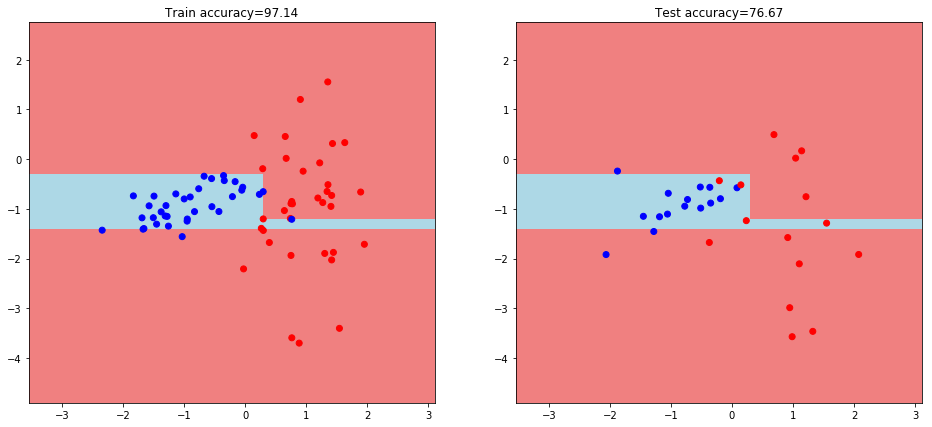

In [106]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_1,np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Построим лес из трех деревьев

In [107]:
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

q= 0.0675
q= 0.35797692990239566
q= 0.1274400286430361
q= 0.368671875
q= 0
q= 0
q= 0.012602394454946514
q= 0.33053047291274446
q= 0
q= 0
q= 0.05120000000000005
q= 0.1604444444444444
q= 0
q= 0.00789115646258507
q= 0.044628099173553704
q= 0.4444444444444444
q= 0
q= 0.0040727272727272695
q= 0.05333333333333318
q= 0
q= 0.2777777777777777
q= 0.42000000000000004
q= 0
q= 0
q= 0
q= 0
q= 0.1652892561983472
q= 0
q= 0.4444444444444444
q= 0
q= 0
q= 0
q= 0
q= 0
q= 0
q= 0
q= 0


In [108]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, train_data)

In [109]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

In [110]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 98.571


In [111]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на тестовой выборке: 83.333


Text(0.5, 1.0, 'Test accuracy=83.33')

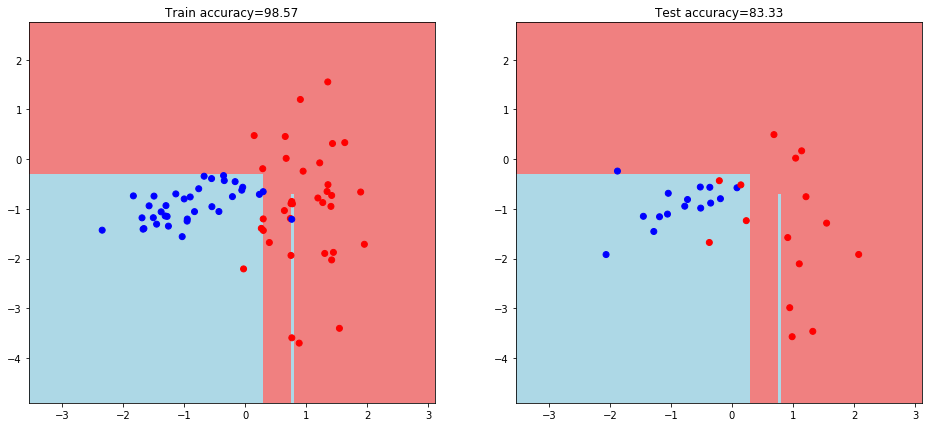

In [112]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_3,np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Построим лес из десяти деревьев

In [113]:
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

q= 0.06292875044754753
q= 0.4454564983888292
q= 0.07863945578231296
q= 0.10417848495330334
q= 0.09196340605207604
q= 0.11574541681079203
q= 0.07828857858933036
q= 0.4686209029066173
q= 0.44562358276644
q= 0.16074211502782937
q= 0.40017743015950596
q= 0
q= 0
q= 0.020775623268698196
q= 0
q= 0.11333333333333334
q= 0
q= 0.3781901752370008
q= 0
q= 0.42663055445457343
q= 0
q= 0.17834424778242236
q= 0
q= 0.4659683085511724
q= 0
q= 0.013314967860422307
q= 0
q= 0.0049382716049383435
q= 0.21215794306703398
q= 0
q= 0
q= 0.022244191794364876
q= 0.07500000000000001
q= 0
q= 0.08408408408408408
q= 0
q= 0
q= 0.0550095238095238
q= 0
q= 0.02902606310013711
q= 0.019684105981482097
q= 0
q= 0
q= 0.014863258026159211
q= 0.375
q= 0
q= 0.08526315789473667
q= 0
q= 0
q= 0.05530864197530869
q= 0.20578231292517005
q= 0
q= 0.48
q= 0
q= 0.3999846218907386
q= 0
q= 0.5
q= 0.09070294784580506
q= 0.5
q= 0.0034666666666666457
q= 0.32000000000000006
q= 0.2603550295857988
q= 0.375
q= 0
q= 0
q= 0
q= 0.006155740227762496
q=

In [114]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_10, train_data)

In [115]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

In [116]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 97.143


In [117]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на тестовой выборке: 83.333


Text(0.5, 1.0, 'Test accuracy=83.33')

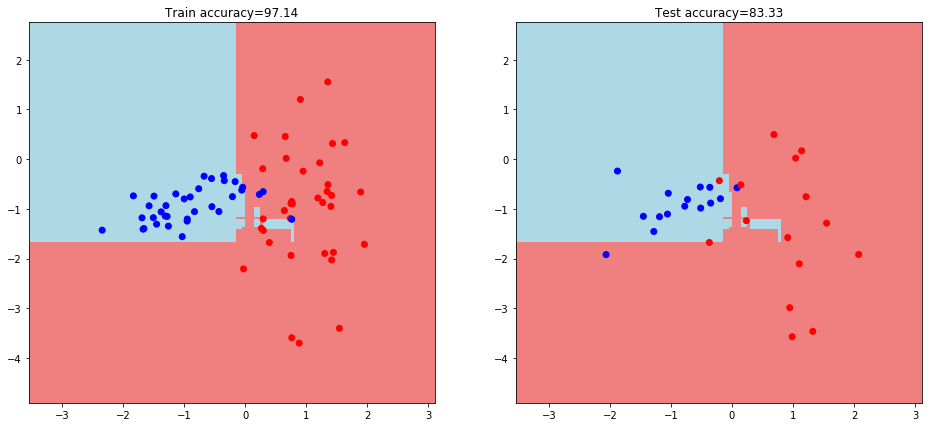

In [118]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_10,np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Построим лес из пятидесяти деревьев

In [119]:
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

q= 0.4179591836734694
q= 0.41979591836734687
q= 0.4656122448979591
q= 0.09159585145533627
q= 0.493469387755102
q= 0.39743589743589747
q= 0.06848841231407832
q= 0.37008068343616524
q= 0.4520930232558139
q= 0.0885319289005923
q= 0.4397897340754483
q= 0.4705477980665951
q= 0.07256235827664398
q= 0.06965986394557838
q= 0.4706362545018007
q= 0.4148476491333635
q= 0.11574541681079203
q= 0.09762139338494014
q= 0.4686209029066173
q= 0.4420408163265307
q= 0.41908163265306125
q= 0.44415489272632125
q= 0.4179591836734694
q= 0.21489795918367344
q= 0.07863945578231313
q= 0.1069758812615954
q= 0.11010396611474765
q= 0.08287097890003453
q= 0.16559423769507808
q= 0.442545018007203
q= 0.4153181272509003
q= 0.08115411681914131
q= 0.08853192890059242
q= 0.13675213675213677
q= 0.10137486573576798
q= 0.14894378804153247
q= 0.4420408163265307
q= 0.43978973407544836
q= 0.103448275862069
q= 0.0918367346938776
q= 0.08115411681914125
q= 0.07600281491907118
q= 0.08287097890003453
q= 0.34489795918367344
q= 0.1094

In [120]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_50, train_data)

In [121]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

In [122]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000


In [123]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на тестовой выборке: 86.667


Text(0.5, 1.0, 'Test accuracy=86.67')

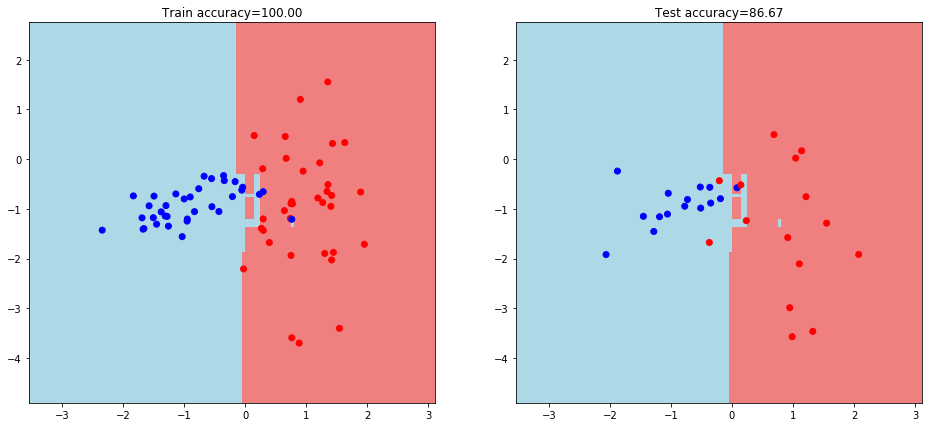

In [124]:
# Визуализируем дерево на графике

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_50,np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

## Домашнее задание

1. Сформировать с помощью `sklearn.make_classification` датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции `predict` на `tree_vote`). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.
2. (*) Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.